## Test the Quantum Annealing Simultation

#### Test the DL-DFT neural network

Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

Data

In [7]:
data=np.load('data/kohm_sham_approach/uniform/dataset_2channels_h_5.0_j_1_1nn_n_10.npz')

ndata=1000

z=data['density']
f=data['density_F']
h=data['potential']


z_torch=torch.from_numpy(z[:ndata])
f_torch=torch.from_numpy(f[:ndata])


model=torch.load('model_rep/kohm_sham/uniform/model_zzxz_reduction_150k_unet_l_train_8_[40, 40, 40, 40, 40, 40]_hc_5_ks_1_ps_6_nconv_0_nblock',map_location='cpu')
model.eval()



TDDFTadiabaticModel(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 2): GELU()
    )
    (2): Sequential(
      (conv3): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 3): GELU()
    )
    (3): Sequential(
      (conv4): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 4): GELU()
    )
    (4): Sequential(
      (conv5): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 5): GELU()
    )
    (5): Sequential(
      (conv6): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation_6): GELU()
    )
  )
  (conv_upsample): 

Look at the domain of the samples

In [ ]:
for i in range(z.shape[-1]):
    plt.hist(z[:,i],label=f'site={i}',bins=200)
    plt.legend()
    plt.show()

Test

In [9]:
f_ml=model(z_torch)
print(f_ml.shape,f_torch.shape)
df=torch.mean(torch.abs(f_ml-f_torch)/torch.abs(f_torch),dim=-1)
print(df.shape)

torch.Size([10, 2, 8]) torch.Size([10, 2, 8])
torch.Size([10, 2])


Visualization $\Delta \mathbf{f}$

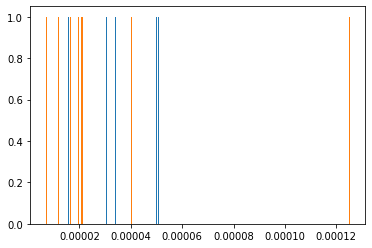

In [10]:
plt.hist(df.detach().numpy(),bins=200)
plt.show()

Visualization, Part 1: $\mathbf{x}[\mathbf{z}]$

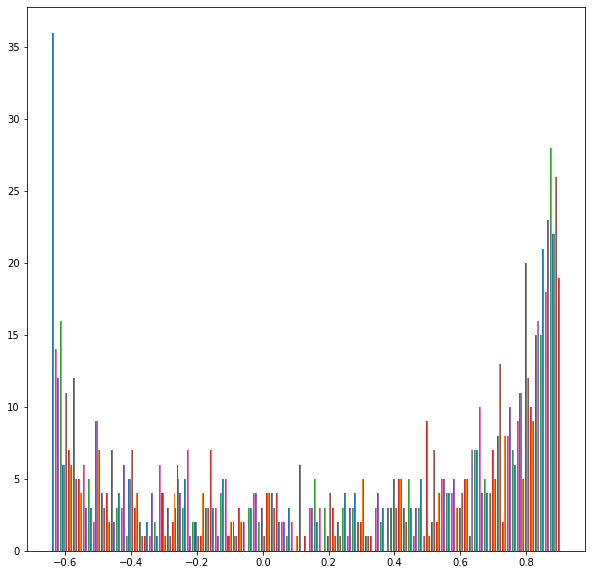

In [9]:
plt.figure(figsize=(10,10))
plt.hist(f_ml[:,0].detach().numpy(),bins=200)
plt.show()

#### Check the DL-DFT Model in the Qutip Dataset of disorder Configurations

Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from src.training.models_adiabatic import Energy_XXZX

Data

In [2]:
data=np.load('data/disorder/test_for_adiabatic_size_8_tf_10.0_dt_0.01_rate_1.0_h_2.7_n_dataset_10.npz')

ndata=1000

z=data['density']
h=data['potential']
time=data['time']

z_torch=torch.from_numpy(z[:ndata])
h_torch=torch.from_numpy(h[:ndata])
print(z_torch.shape)

model=torch.load('model_rep/kohm_sham/model_zzxz_reduction_150k_unet_l_train_8_[40, 40, 40, 40, 40, 40]_hc_5_ks_1_ps_6_nconv_0_nblock',map_location='cpu')
model.eval()

energy=Energy_XXZX(model=model)


torch.Size([10, 1000, 8])


Test of the energy functional over the evolution configurations $\mathbf{z}(t)$

In [3]:
emls:List[np.ndarray]=[]

#sample
for i in range(z_torch.shape[0]):
    e_ml=energy(z_torch[i],h_torch[i])
    emls.append(e_ml.detach().numpy())

Visualization

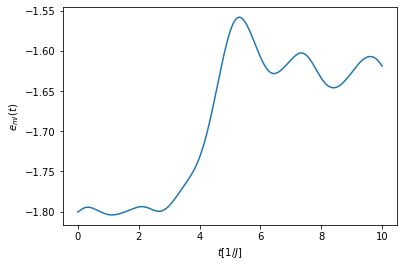

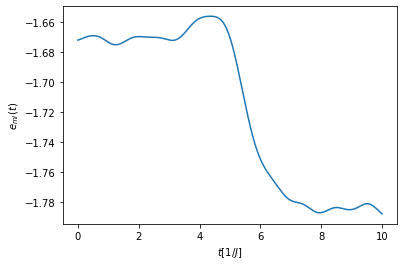

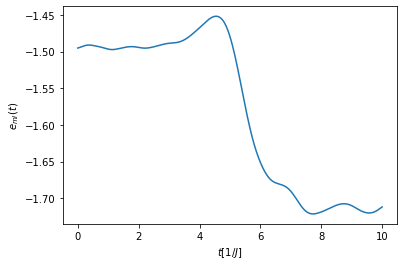

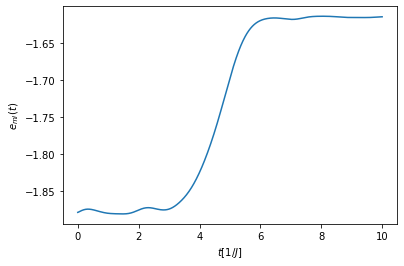

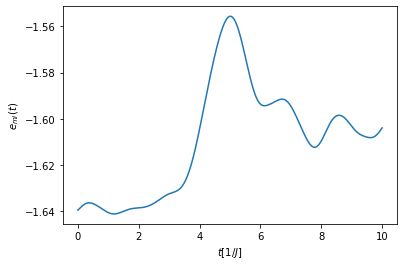

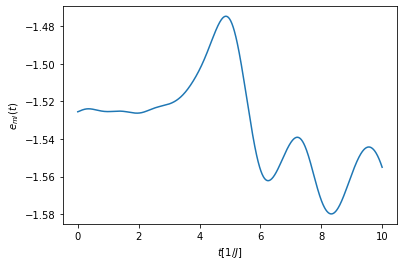

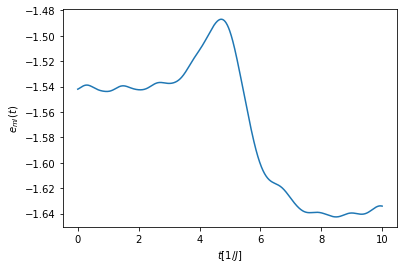

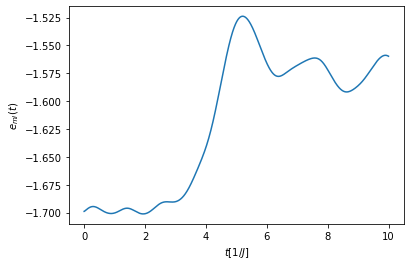

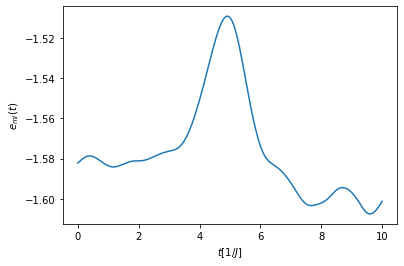

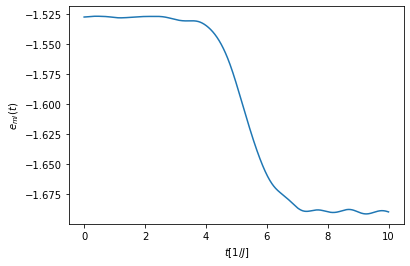

In [5]:
for e in emls:
    plt.plot(time,e)
    plt.xlabel(r'$t [1/J]$')
    plt.ylabel(r'$e_{ml}(t)$')
    plt.show()

Functional derivative of $\braket{\hat{Z}_i \hat{Z}_{i+1}}=f_i$ over the evolution configuration $\mathbf{z}(t)$

In [ ]:
grads:List[np.ndarray]=[]

z_torch.requires_grad_(False)

for i in range(z_torch.shape[0]):
    phi=z_torch[i]
    phi.requires_grad_(True)
    f=model(phi).mean(-1)[:,0]
    print(f.shape)
    f.backward(torch.ones_like(f))
    print(phi.requires_grad)
    with torch.no_grad():
            grad = phi.grad.clone()
            print(grad.shape)
            grads.append(grad.detach().numpy())
            phi.grad.zero_()
            



Visualization

(1000, 8)


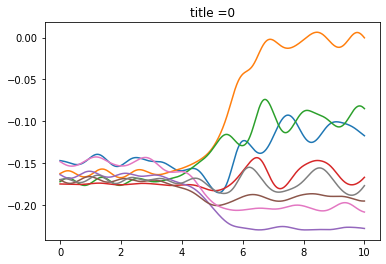

(1000, 8)


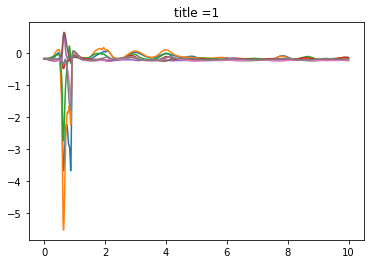

(1000, 8)


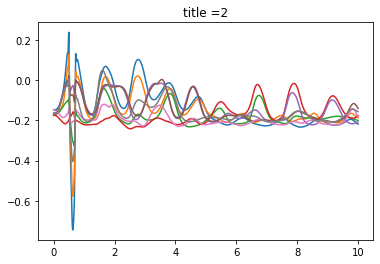

(1000, 8)


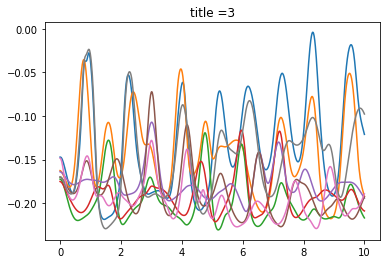

(1000, 8)


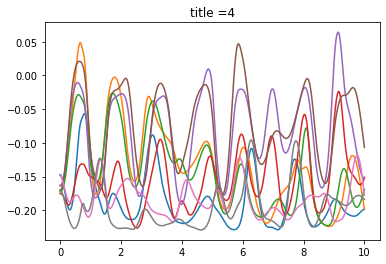

(1000, 8)


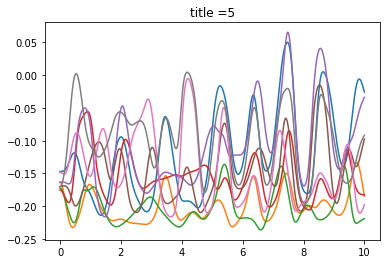

(1000, 8)


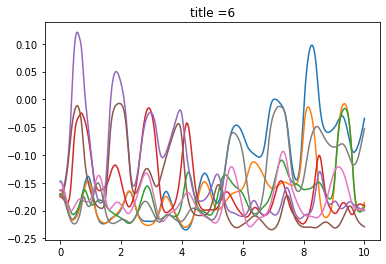

(1000, 8)


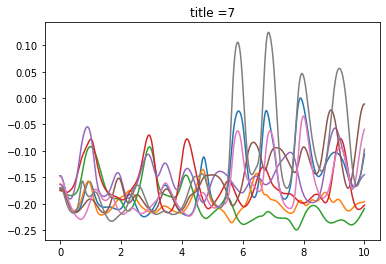

(1000, 8)


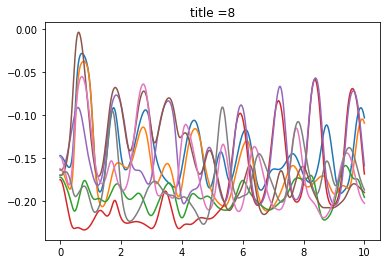

(1000, 8)


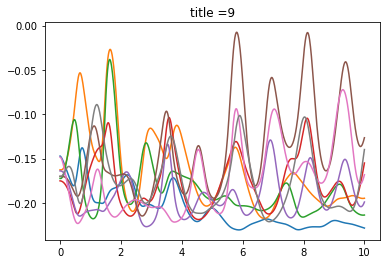

In [33]:
for i,grad in enumerate(grads):
    plt.title(f'title ={i}')
    print(grad.shape)
    plt.plot(time,grad)
    plt.show()

This study check the stability of the DL-DFT method tested on possible time evolution samples like $\mathbf{z}(t)$. This is the starting point to apply the Crank-Nicholson algorithm